# Phase Slope Index method

### Purpose
This is a walk-through notebook on *Robustly Estimating the Flow Direction of Information in Complex Physical Systems* paper, by *Guido Nolte, Andreas Ziehe, Vadim V. Nikulin, Alois Schlögl, Nicole Krämer, Tom Brismar, and Klaus-Robert Müller*, implementated in Julia-Language (please see http://doc.ml.tu-berlin.de/causality/ and [Nolte et al. 2008](http://link.aps.org/abstract/PRL/v100/e234101)).

### Acknowledgement
This work was funded by the German Federal Ministry of Education and Research [(BMBF)](https://www.bmbf.de/) in the project ALICE III under grant ref. 01IS18049B.

## Setting up Julia Env.

In [1]:
# Add packages
# import Pkg
# Pkg.add("FFTW")
# Pkg.add("DSP")
# Pkg.add("Plots")
# Pkg.add("MAT")
# Pkg.add("Einsum")

# imports for PSI
using Statistics: mean, std
using FFTW: fft
using Einsum

# imports for notebook
using Random: randperm
using MAT: matread
using Plots: plot, heatmap, cgrad
using DSP: blackman
;

## Data
`mixed_data` four channcels, where:
- channels 1 and 2 are i.i.d. uniform [0, 1] noise
- channel 3 is delayed (by 1 sample) channel 1
- channel 4 is delayed (by 16 samples) channel 1 plus i.i.d. uniform [0, 0.2] noise 


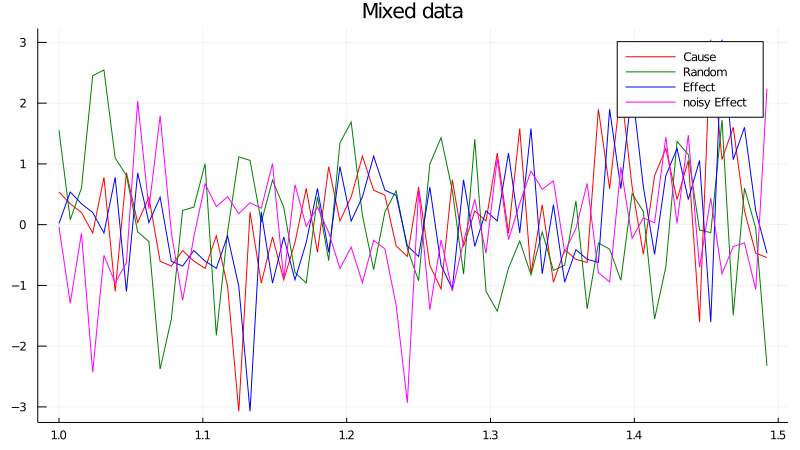

In [2]:
# data generation
n_channels = 4  # number of channels
n_samples = 65536  # = 2^16 number of data points measured in each channel
fs = 128  # sampling frequency
time_array = Array(range(1, step=1/fs, length=n_samples))

# mixed data
rand_data = randn(Float64, (n_samples+16, 1)) # 
cause_source = rand_data[16:n_samples+15]  # channel 1
random_source = randn(Float64, n_samples)  # channel 2
effect_source = rand_data[15:n_samples+14]  #channel 3
weak_effect = rand_data[1:n_samples] .- (randn(Float64, (n_samples, 1)) ./ 5)
mixed_data = hcat(cause_source, random_source, effect_source, weak_effect)


p1 = plot(time_array[1:64], mixed_data[1:64, :],
         title = "Mixed data",
         label = ["Cause" "Random" "Effect" "noisy Effect"],
         linecolor = ["red" "green" "blue" "magenta"])

plot(p1, layout=(1, 1), size=(800, 450))


## PSI

In [3]:
# include("../src/PhaseSlopeIndex.jl")
using PhaseSlopeIndex

┌ Info: Precompiling PhaseSlopeIndex [d75d2fe3-70b5-44f4-a698-e19bbf534063]
└ @ Base loading.jl:1278


In [4]:
? data2psi

search: data2psi



```
data2psi(data, seglen [, segshift, eplen, freqlist, method,
                         nboot, segave, subave, detrend])
```

calculates phase slope index (PSI)

### Arguments

  * `data::AbstractArray`: NxM array for N data points in M channels
  * `seglen::Integer`: segment length (determinds the frequency resolution)

*optional arguments*

  * `segshift::Integer`: number of bins by which neighboring segments are shifted (default=seglen/2)
  * `eplen::Integer`: length of epochs (if eplen=0, eplen is defaulted to number of samples)
  * `freqlist::AbstractArray`: 2D Array where each column is a frequency band (default is full range)
  * `method::String`: standard deviation estimation method (default is "jackknife")
  * `nboot::Integer`: number of bootstrap resamplings (default is 100)
  * `segave::Bool`: if true, average across CS segments (default is false)
  * `subave::Bool`: if true, subtract average across CS segments (default is false)
  * `detrend::Bool`: if true, performes a 0th-order detrend across raw segments (default is false)
  * `window::Function`: window function with interval length as sole necessary argument (default is Hanning)

### Returns

  * `psi::AbstractArray`: channel x channel PSI
  * `psi_se::AbstractArray`: channel x channel PSI estimated standard error


# Example 1.
PSI is calculated over all frequencies for segmented (`seglen = 100`) but continuous data (single epoch, `nep = 1`) and estimation of error using Bootstrap method for 256 resampling iterations (`nboot=256`). The default window function (Hanning window) is used.

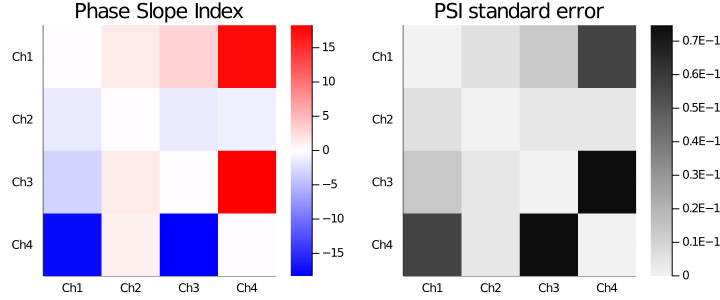

In [5]:
seglen = 100  # segment length
nboot = 256  # number of bootstrap iterations
method = "bootstrap"  # standard error estimation method

psi, psi_se = data2psi(mixed_data, seglen, nboot=nboot, method=method)

p1 = heatmap(psi, ticks=false, yflip = true,
             yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             color=cgrad(:bwr), title="Phase Slope Index")

p2 = heatmap(psi_se, ticks=false, yflip = true,
             yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             color=cgrad(:grays, rev = true), title="PSI standard error")

plot(p1, p2, layout=(1, 2), size=(720, 300))

# Example 2.
PSI is calculated over 3 frequency bands, for partitioned data to segments (`seglen = 100`) and epochs (`eplen = 200`), estimation of error using Jackknife method (default). The window function is set to blackman (imported from DSP.jl). The plots are for only one of the frequency ranges.

We normalize the PSI by dividing it by estimated standard error.

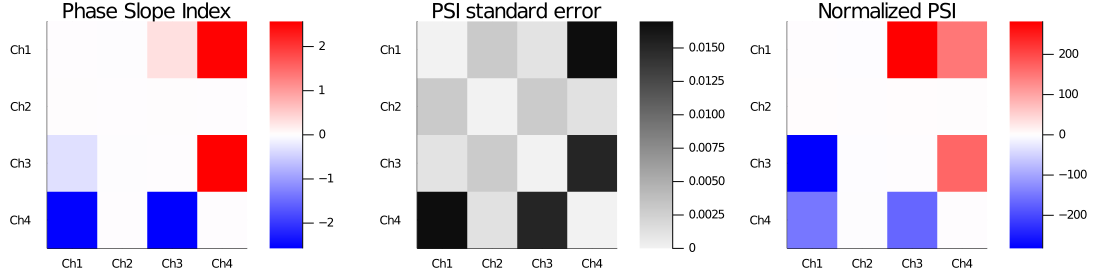

In [6]:
seglen = 100  # segment length
eplen = 200  # epoch length
method = "jackknife"  # standard error estimation method

# three frequency bands
freqlist = [[5:1:10;] [6:1:11;] [7:1:12;]]

segave = true  # average across CS segments
subave = true  # subtract average across CS segments
detrend = true  # performes a 0th-order detrend across raw segments
window = blackman  # blackman window function

psi, psi_se = data2psi(mixed_data, seglen, subave=subave, segave=segave, detrend=detrend,
                             freqlist=freqlist, eplen=eplen, method=method, window=blackman)

psi_normed = psi ./ (psi_se .+ eps())

p1 = heatmap(psi[:, :, 1], ticks=false, yflip = true,
             yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             color=cgrad(:bwr), title="Phase Slope Index")

p2 = heatmap(psi_se[:, :, 1], ticks=false, yflip = true,
             yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             color=cgrad(:grays, rev = true), title="PSI standard error")

p3 = heatmap(psi_normed[:, :, 1], ticks=false, yflip = true,
             yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
             color=cgrad(:bwr), title="Normalized PSI")

plot(p1, p2, p3, layout=(1, 3), size=(1110, 270))